# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Siamese Dataset class](#1b)
    - [Define Dataset Transformations](#1c)
    - [Define Train-Valid-Test splits](#1d)
    - [Create Datasets](#1e)
    - [Visualize Batches](#1f)
2. [Define Model](#2)
    - [Contrastive Loss](#2a)
    - [Train Model twice](#2b)
    - [Load trained Models](#2c)
3. [Inference](#3)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download Face and signature-verification Dataset<a class="anchor" id="1a"></a>
###### (You will be prompted to enter your Kaggle credentials)

In [ ]:
import opendatasets as od 
import pandas 

od.download('https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/data')
!mv att-database-of-faces faces
!mv faces data/faces

In [ ]:
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 
!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Siamese Dataset class<a class="anchor" id="1b">

In [3]:
class SiameseDataset(Dataset):
    """
    A custom Dataset class for Siamese networks. It returns pairs of images from a given subset, where 
    approximately 50% of the pairs are of the same class and 50% are of different classes.

    Attributes:
        subset (torch.utils.data.Subset): A subset of the dataset containing image paths and labels.
        transform (callable, optional): A function/transform to apply to the images.

    Methods:
        __getitem__(index): Retrieves a pair of images (either of the same class or different classes) 
                            along with a label indicating whether they are the same or different.
        __len__(): Returns the length of the dataset.
    """
    def __init__(self, subset, transform=None):
        """
        Initializes the SiameseDataset with a given subset and optional transformations.

        Args:
            subset (torch.utils.data.Subset): A subset of the dataset containing image paths and labels.
            transform (callable, optional): A function/transform to apply to the images. Defaults to None.
        """
        self.subset = subset
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform
        
    def __getitem__(self, index):
        """
        Retrieves a pair of images (either of the same class or different classes) along with a label 
        indicating whether they are the same or different.

        Args:
            index (int): Index of the primary image in the subset.

        Returns:
            tuple: A tuple containing:
                - img0 (torch.Tensor): The first image in the pair.
                - img1 (torch.Tensor): The second image in the pair.
                - label (torch.Tensor): A tensor containing a single value, 0 if the images are of the same 
                                       class, 1 if they are of different classes.
        """
        index = self.indices[index]
        img0_tuple = self.dataset.imgs[index]

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The number of images in the subset.
        """
        return len(self.indices)

#### Define Dataset Transformations<a class="anchor" id="1c">

In [4]:
# Define the transformations for train, validation, and test
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#### Define Train-Valid-Test splits<a class="anchor" id="1d">

In [5]:
# Define Dataset Folder
face_folder_dataset = datasets.ImageFolder(root="./data/faces/")
signature_folder_dataset = datasets.ImageFolder(root="./data/signature/full")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(face_folder_dataset))
valid_size = int(0.1 * len(face_folder_dataset))
test_size = len(face_folder_dataset) - train_size - valid_size
face_train_dataset, face_valid_dataset, face_test_dataset = torch.utils.data.random_split(face_folder_dataset, [train_size, valid_size, test_size])


# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(signature_folder_dataset))
valid_size = int(0.1 * len(signature_folder_dataset))
test_size = len(signature_folder_dataset) - train_size - valid_size
signature_train_dataset, signature_valid_dataset, signature_test_dataset = torch.utils.data.random_split(signature_folder_dataset, [train_size, valid_size, test_size])


#### Create Datasets<a class="anchor" id="1e">

In [6]:
# Apply the transformations
face_train_dataset = SiameseDataset(subset=face_train_dataset, transform=train_transform)
face_valid_dataset = SiameseDataset(subset=face_valid_dataset, transform=valid_test_transform)
face_test_dataset = SiameseDataset(subset=face_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")

Number of training samples: 320
Number of validation samples: 40
Number of testing samples: 40


In [7]:
# Apply the transformations
signature_train_dataset = SiameseDataset(subset=signature_train_dataset, transform=train_transform)
signature_valid_dataset = SiameseDataset(subset=signature_valid_dataset, transform=valid_test_transform)
signature_test_dataset = SiameseDataset(subset=signature_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 3431
Number of validation samples: 428
Number of testing samples: 430


#### Visualize Batches<a class="anchor" id="1f">

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8117647].


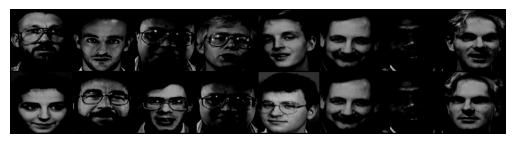

In [8]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_test_dataset, shuffle=True, num_workers=2, batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62352943..1.0].


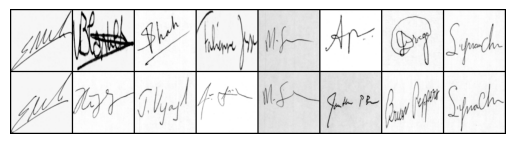

In [9]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

### Define Contrastive Loss <a class="anchor" id="2a">

In [10]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):      
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)      
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

### Train SiameseNetwork twice <a class="anchor" id="2b">

Training the model for 100 epochs:  41%|████      | 41/100 [00:44<01:03,  1.07s/it]

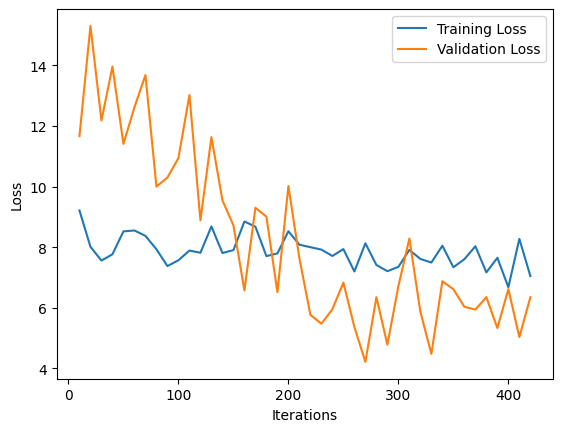

Training the model for 100 epochs:  41%|████      | 41/100 [00:45<01:04,  1.10s/it]


saved model checkpoint


In [14]:
import SiameseNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.00001)
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 100, patience=15)

checkpoint = {'model_state_dict': face_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/face_net2.pt')
print('saved model checkpoint')

In [ ]:
signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=128)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=128)

signature_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()

optimizer = optim.Adam(signature_net.parameters(), lr = 0.00001)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, criterion, epochs=100, patience=15)


checkpoint = {'model_state_dict': signature_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/signature_net.pt')
print('saved model checkpoint')

### Load trained models <a class="anchor" id="2c">

In [8]:
import SiameseNetwork

face_net = SiameseNetwork.SiameseNetwork().cuda()
face_model_path = f"./checkpoints/face_net.pt"
face_state_dict = torch.load(face_model_path)
face_net.load_state_dict(face_state_dict['model_state_dict'])

signature_net = SiameseNetwork.SiameseNetwork().cuda()
signature_model_path = f"./checkpoints/signature_net.pt"
signature_state_dict = torch.load(face_model_path)
signature_net.load_state_dict(signature_state_dict['model_state_dict'])

/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

[Back to the top](#0) 

## Inference <a class="anchor" id ="3">

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


face distance tensor([0.4883], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


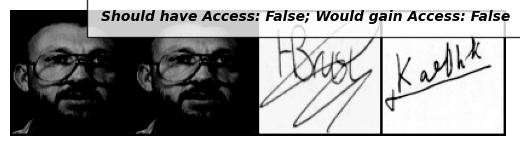

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.96862745].


face distance tensor([2.0538], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


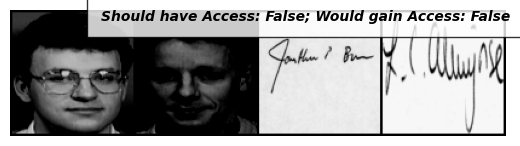

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


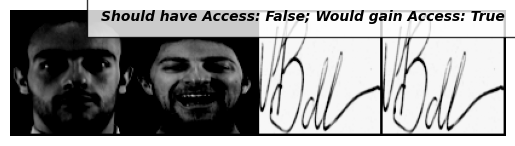

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


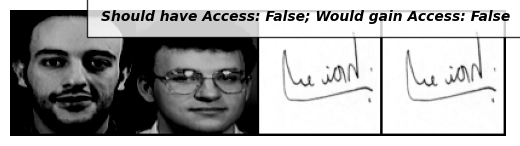

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


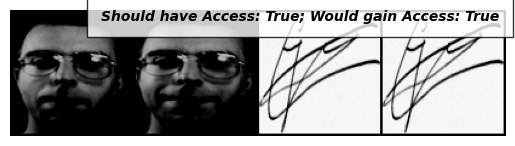

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.92156863].


face distance tensor([0.4818], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


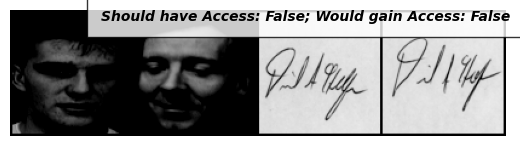

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


face distance tensor([3.0801], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


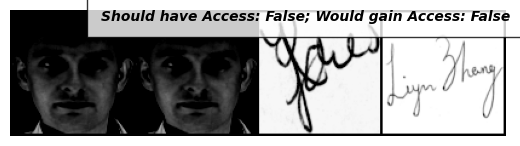

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.96862745].


face distance tensor([3.4832], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


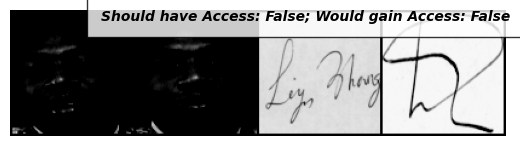

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


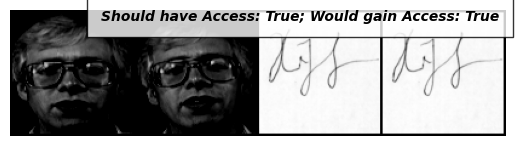

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


face distance tensor([1.1952], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


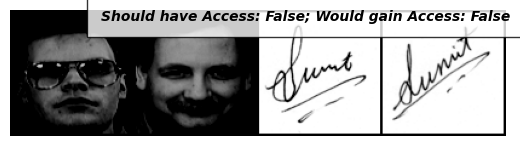

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.96862745].


face distance tensor([0.6395], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


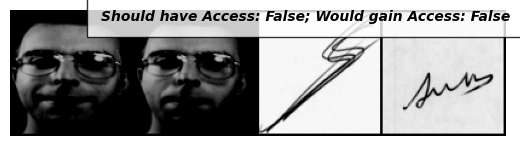

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].


face distance tensor([1.4899], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


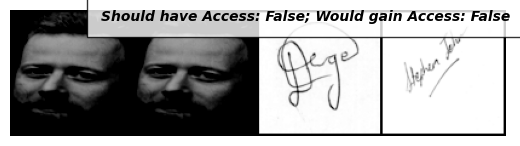

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


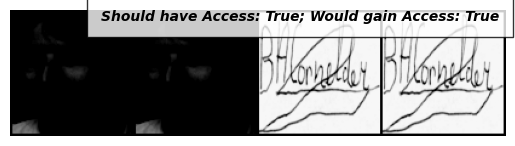

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


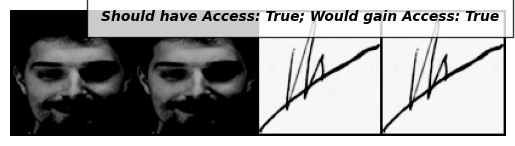

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.96862745].


face distance tensor([1.0252], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


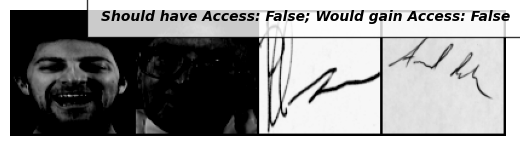

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


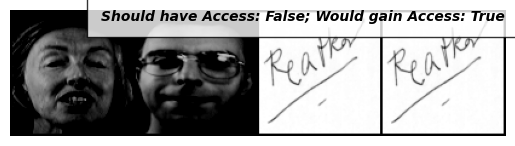

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


face distance tensor([0.9393], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


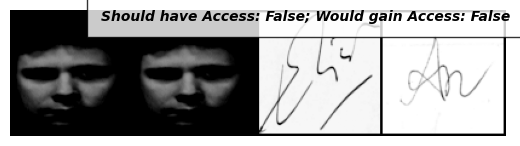

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([1.5859], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


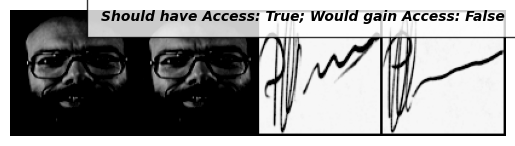

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([0.0313], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


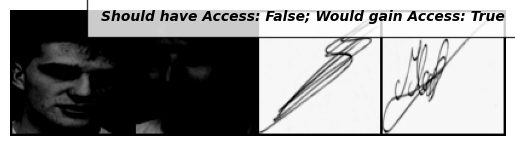

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.9372549].


face distance tensor([0.7002], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


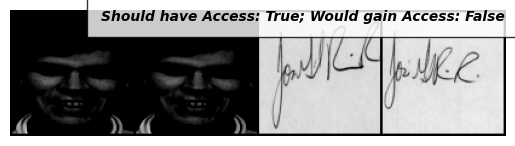

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


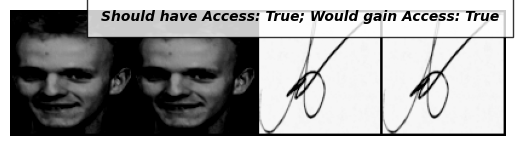

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


face distance tensor([0.3854], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


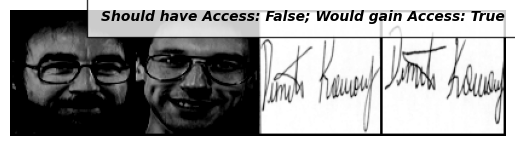

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.99215686].


face distance tensor([1.1883], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


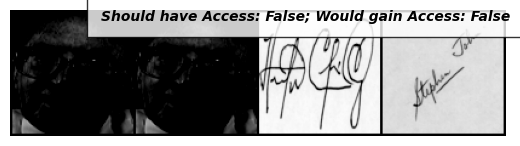

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


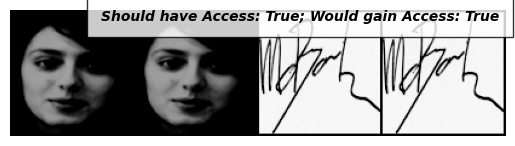

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


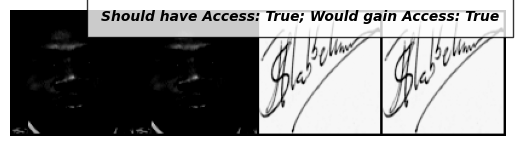

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


face distance tensor([0.8533], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


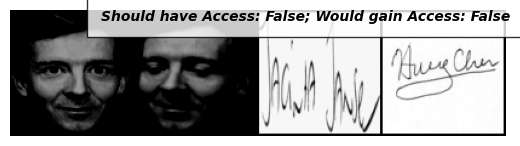

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.96862745].


face distance tensor([1.4105], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


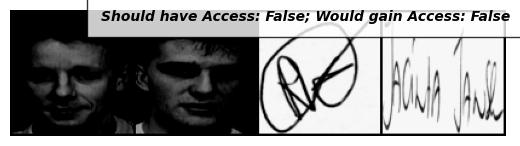

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


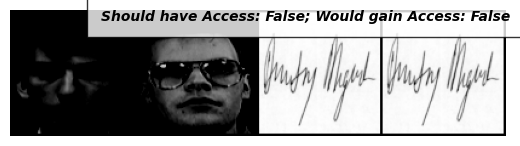

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


face distance tensor([1.1990], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


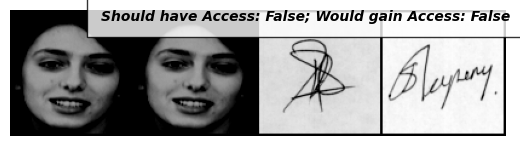

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([1.9842], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


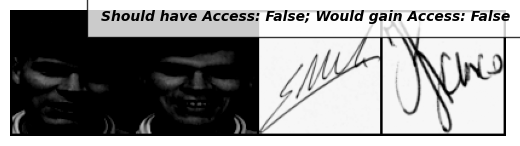

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


face distance tensor([0.9731], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


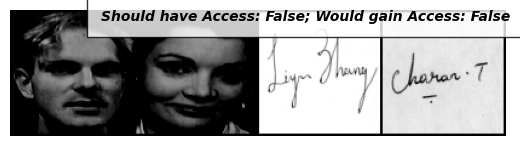

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].


face distance tensor([0.6674], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


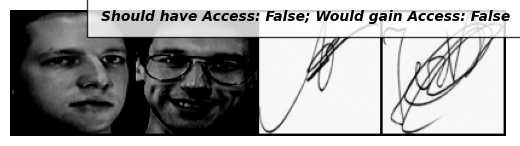

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..1.0].


face distance tensor([0.3341], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


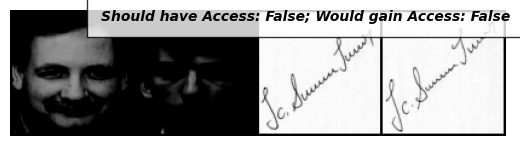

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].


face distance tensor([0.4611], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


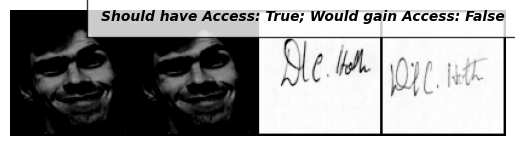

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.96862745].


face distance tensor([1.0418], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


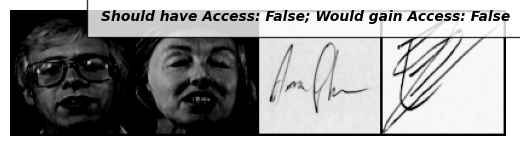

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


face distance tensor([0.4486], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


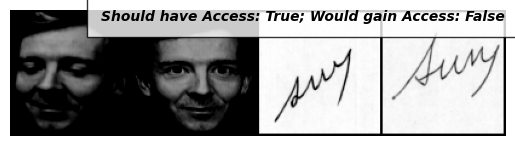

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.96862745].


face distance tensor([0.9993], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


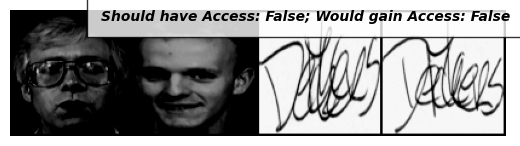

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9372549].


face distance tensor([0.3430], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


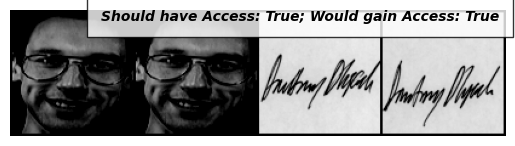

face distance tensor([1.2322], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].


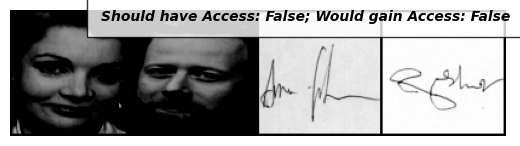

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


face distance tensor([0.8251], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


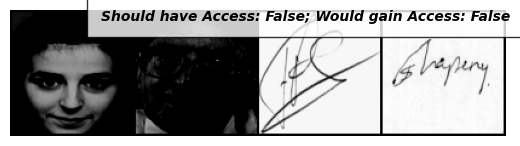

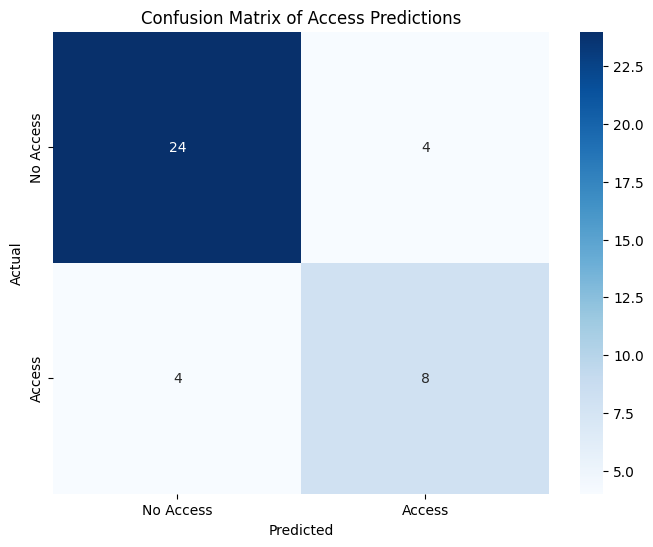

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Locate the test dataset and load it into the SiameseNetworkDataset
face_net.eval()
signature_net.eval()

face_test_dataloader = DataLoader(face_test_dataset, num_workers=2, batch_size=1, shuffle=True)
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=1)

# Grab one image that we are going to test
face_dataiter = iter(face_test_dataloader)
signature_dataiter = iter(signature_test_loader)

should_have_access_list = []
would_gain_access_list = []

for i in range(len(face_test_dataloader)):
    # Iterate over 5 images and test them with the first image (x0)
    face0, face1, face_label = next(face_dataiter)
    signature1, signature2, forge_label = next(signature_dataiter)

    face_output1, face_output2 = face_net(face0.cuda(), face1.cuda())
    euclidean_distance = F.pairwise_distance(face_output1, face_output2)
    #print(f"face distance {euclidean_distance}; label {face_label}")
    face_distance = (euclidean_distance < 1.5).bool()

    signature_output1, signature_output2 = signature_net(signature1.cuda(), signature2.cuda())
    #print(torch.sigmoid(forgery_output).bool())
    euclidean_distance = F.pairwise_distance(signature_output1, signature_output2)
    print(f"face distance {euclidean_distance}; label {forge_label}")

    signature_distance = (euclidean_distance < 0.4).bool()
    
    # Concatenate the two images together
    concatenated = torch.cat((face0, face1, signature1, signature2), 0)
    would_gain_access = face_distance.cpu()[0] and signature_distance.cpu()[0]
    should_have_access = not face_label.cpu()[0][0].bool() and not forge_label.cpu()[0][0].bool() 
    should_have_access_list.append(should_have_access)
    would_gain_access_list.append(would_gain_access)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Should have Access: {should_have_access}; Would gain Access: {would_gain_access}')


# Create confusion matrix
conf_matrix = confusion_matrix(should_have_access_list, would_gain_access_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Access', 'Access'], yticklabels=['No Access', 'Access'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Access Predictions')
plt.show()

[Back to the top](#0) 